In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
sns.set(style="whitegrid")

# Class definition

In [2]:
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed 
        
        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
#         numerator = np.exp(-((x-mean)**2 / (2 * var)))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
     

    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)
        

        fig.suptitle('True vs Predicted Comparison', fontsize=20)

        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("True values", fontsize=18)
        ax[1].set_title("Predicted values", fontsize=18)
        plt.show()

# Read an clean dataset

In [3]:
# read
df = pd.read_csv("spotify-dataset.csv")

# shuffle dataset with sample
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

# lower the attribute
df['Top Genre'] = (df["Top Genre"].str.strip()).str.lower()

# drop genres that have less than 20 instances
to_remove = [genre for genre in df['Top Genre'].unique() if df['Top Genre'].value_counts()[genre] < 20] 
for r in to_remove:
    df = df[df['Top Genre'] != r]

# convert negative values to positive, because the percenption of sound is relative (-N dB == N dB in human ear)
df['Loudness (dB)'] = df['Loudness (dB)'].abs()

# convert duration to int
df['Length (Duration)'] = pd.to_numeric(df['Length (Duration)'].str.replace(',',''))

# drop not used columns
df.drop(['Title', 'Artist', 'Year', 'Index'], axis=1, inplace=True)

# encode genres
# genres = list(df['Top Genre'].unique())
# df['Top Genre'] = df['Top Genre'].apply(lambda x: genres.index(x))

In [4]:
df

,Top Genre,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,adult standards,76,40,34,9,11,7,291,76,4,47
1,british soul,104,82,72,7,24,82,249,15,3,49
2,irish rock,96,60,53,6,11,35,305,0,2,57
4,album rock,60,22,23,13,27,18,214,95,3,66
5,alternative rock,96,80,22,6,9,26,291,0,4,37
...,...,...,...,...,...,...,...,...,...,...,...
1989,dance rock,116,19,56,13,11,12,321,73,3,53
1990,album rock,77,57,54,8,9,73,290,1,16,66
1991,classic uk pop,167,52,18,8,6,42,222,39,3,48
1992,pop,180,66,51,7,12,46,228,3,4,79


# Perform analysis

The analisis performed, conssits in a classification with naive bayes, that ....

### Prepare data

In [5]:
# set features and target
X, y = df.drop('Top Genre', axis=1), df.iloc[:, 0]

# split on train and test 0.7/0.3
X_train, X_test, y_train, y_test = X[:1000], X[1000:], y[:1000], y[1000:]

### Train model

In [6]:
# train the model
model = NaiveBayesClassifier()
model.fit(X_train, y_train)

### Perform validation predictions

In [7]:
predictions = model.predict(X_test)

### Calculate accuracy and score values

In [8]:
# It has low accuracy because there are categories or genres missing in the predictions
model.accuracy(y_test, predictions)

0.2

### Set statistics

In [9]:
# Count percentage of probability of each ocurrence in each category or genre
y_test.value_counts(normalize=True)

album rock           0.294624
adult standards      0.081720
dutch pop            0.068817
alternative metal    0.047312
alternative rock     0.045161
permanent wave       0.040860
dance rock           0.040860
dutch indie          0.038710
modern rock          0.038710
classic rock         0.036559
pop                  0.036559
glam rock            0.036559
art rock             0.036559
dance pop            0.034409
dutch cabaret        0.023656
irish rock           0.023656
classic uk pop       0.021505
british invasion     0.021505
europop              0.017204
british soul         0.015054
Name: Top Genre, dtype: float64

In [14]:
# Count predictions made
# c = Counter(predictions)
# c.most_common()
{n: round(float(predictions.count(n))/float(len(predictions)), 2) for n in predictions}

{'classic uk pop': 0.1,
 'adult standards': 0.11,
 'dutch indie': 0.1,
 'europop': 0.14,
 'irish rock': 0.05,
 'alternative rock': 0.06,
 'modern rock': 0.11,
 'permanent wave': 0.09,
 'album rock': 0.09,
 'alternative metal': 0.02,
 'british invasion': 0.03,
 'dance rock': 0.0,
 'british soul': 0.03,
 'dutch pop': 0.02,
 'dance pop': 0.03,
 'art rock': 0.0,
 'dutch cabaret': 0.0}

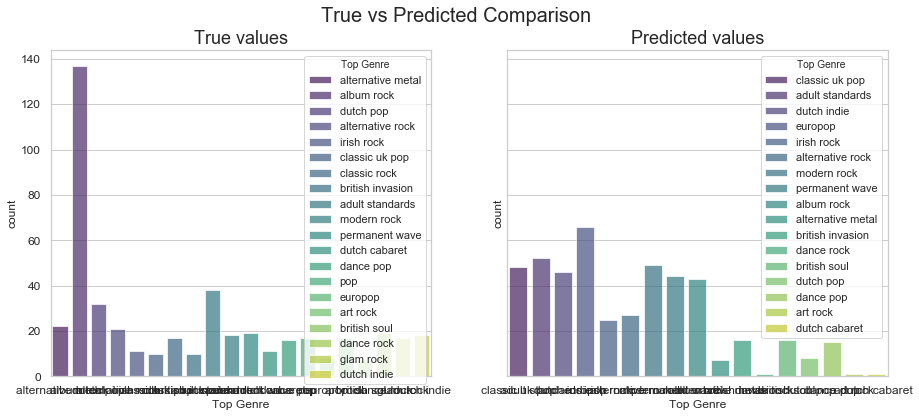

In [11]:
# Visualize predictions
model.visualize(y_test, predictions, 'Top Genre')